#                                                                                                                     **Rapport du projet IA (probleme: placement de 8 reines sur echiquier sous contraintes) réalisé par Mohamed Elyes Maalel & Donia Tekaya**

- Dans le problème des 8 reines, les variables représentent les positions des reines sur l'échiquier. Chaque variable correspond à une colonne de l'échiquier, et la valeur associée à chaque variable est la colonne où la reine est placée dans cette ligne.

* **Variables:**

Dans le cas des 8 reines, nous avons 8 variables, une pour chaque colonne de l'échiquier.

* **Domaine:**

Le domaine de chaque variable représente les colonnes possibles où une reine peut être placée dans une ligne spécifique. Puisqu'il y a 8 colonnes sur un échiquier de 8x8, le domaine de chaque variable sera [1, 2, 3, 4, 5, 6, 7, 8].

* **Contraintes:**

Les contraintes du problème des 8 reines sont les suivantes : Aucune reine ne peut menacer une autre reine sur la même ligne, la même colonne ou la même diagonale. Autrement dit, deux reines ne peuvent pas être placées sur la même ligne, la même colonne ou la même diagonale. Chaque reine doit être placée dans une colonne différente.

* **Le but de la fonction CSP:** est de représenter un problème de satisfaction de contraintes (CSP). Cette classe encapsule les informations et les fonctionnalités nécessaires pour définir et résoudre un CSP. Elle permet de modéliser les domaines des variables, de gérer les variables non assignées et de stocker les affectations de variables.

In [54]:
import time
from random import randint
import matplotlib.pyplot as plt

In [55]:
def csp(n):
    domains = {}
    unassigned = set()
    for i in range(n):
        unassigned.add(i)
        values = list(range(n))
        domains[i] = values

    return domains, unassigned
# Variable globale pour stocker le nombre total de nœuds explorés
nodes_explored = 0

* le but de la fonction **queen_constraint** est une fonction booleene qui permet de vérifier si deux reines placées sur deux positions différentes de l'échiquier respectent les contraintes du problème.

In [56]:
def queen_constraint(A, a, B, b):
    """A et B representent 2 colonnes
       a et b reprensentent 2 lignes"""
    if A == B:
        return True  # Meme colonne, pas de contrainte
    if a == b:
        return False  # Meme ligne, contrainte violée

    # Vérification des diagonales
    if A + a == B + b or A - a == B - b:
        return False  # Meme diagonale, contrainte violée

    return True  # Aucune contrainte violée




la fonction **get_all_pairs(n)**  génére toutes les paires possibles de positions d'échiquier pour placer des reines, à l'exception des paires où les reines seraient sur la même colonne.

In [57]:
def get_all_pairs(n):
    return [(i, j) for i in range(n) for j in range(n) if i != j]

* Cette fonction est l'algorithme principal de réduction de domaine.

* lorsque  **AC3** est appliqué à un **CSP**, il reduit progressivement les domaines des variables en eliminant les valeurs qui ne satisfont pas les contraintes du problème.

* Dans le contexte de l'algorithme **AC3 (Arc Consistency Algorithm 3)**, avoir une solution signifie que toutes les contraintes du problème de satisfaction de contraintes (CSP) ont été satisfaites après l'application de l'algorithme AC3 pour réduire les domaines des variables.

In [58]:
def AC3(domains, constraints, constraint_function):
    """Algorithme d'inférence AC3 pour réduire les domaines."""
    global nodes_explored
    queue = list(constraints)
    while queue:
        (Xi, Xj) = queue.pop(0)
        nodes_explored += 1  # Incrémenter le compteur à chaque nœud exploré
        if revise(domains, Xi, Xj, constraint_function):
            if len(domains[Xi]) == 0:
                return False
            for Xk in (set(constraints[Xi]) - {Xj}):
                queue.append((Xk, Xi))
    return True

def revise(domains, Xi, Xj, constraint_function):
    """Vérifie si la révision est nécessaire."""
    revised = False
    for x in domains[Xi]:
        if not any(constraint_function(Xi, x, Xj, y) for y in domains[Xj]):
            domains[Xi].remove(x)
            revised = True
    return revised


**Le but de la fonction is_safe:** vérifier si une position spécifique sur un échiquier est sûre pour placer une reine, en tenant compte des reines déjà placées sur l'échiquier. Elle parcourt toutes les reines déjà placées et vérifie s'il existe un conflit avec la position spécifique en termes de colonnes et de diagonales.

In [59]:
def is_safe(x, y, assignments):
    for i, j in assignments:
        if (i, j) != (x, y): #cette condition vérifie si la position (x, y) n'est pas égale à l'une des positions déjà occupées par une reine dans assignments
            if (y + x == j + i) or (y - x == j - i): #Cette condition vérifie si la nouvelle reine en (x, y) attaque une autre reine en diagonale.
                return False
            elif j == y: # cette condition verifie si la nouvelle reine est dans la meme colonne que l'autre reine
                return False
    return True


Le but de la fonction **get_domain** est de déterminer les colonnes dans une ligne spécifiée où il est sécurisé de placer une reine, en évitant les attaques avec les reines déjà placées.

In [60]:
def get_domain(assignments, row, domains):
    values = []
    for col in domains[row]:
        if is_safe(row, col, assignments):
            values.append(col)

    return values



*

La fonction **update_domains** retourne les nouveaux domaines mis à jour, un booléen indiquant si une affectation est impossible pour cette branche, et  l'index de la ligne de l'échiquier  à partir de laquelle l'algorithme devrait commencer à verifier les variables qui n'ont pas encore été assignees..

In [61]:
def update_domains(assignments, domains, unassigned, n, mrv=False):
    min_size = float('inf')#Initialise la taille minimale des domaines à une valeur infinie pour commencer.
    new_domains = {} # Initialise un dictionnaire vide pour stocker les nouveaux domaines des variables.
    next_row = len(assignments) # on commence à vérifier à partir de la prochaine ligne non assignée
    min_list = []

    for i in unassigned: #Parcourt toutes les variables non assignée
        values = get_domain(assignments, i, domains) #obtenir les valeurs possibles de la variable i en fonction des contraintes satisfaites par les assignations actuelles
        if len(values) == 0:
            return {}, True, next_row  #s'i n'ya a pas de valeur possible pour cette variable on passe a la ligne suivante
        new_domains[i] = values #affecter a la variable i son domaine
        """Cette heuristique(MRV) est utilisée pour choisir la prochaine variable à affecter lors de la résolution d'un problème de contraintes.
         L'objectif est de choisir la variable avec le domaine le plus restreint,
         c'est-à-dire celui qui a le moins de valeurs possibles, afin de réduire le nombre de branches à explorer dans l'arbre de recherche."""
        if mrv:
            size = len(values)
            if size == min_size: #si la taille du domaine est égale à la taille minimale trouvée précédemment, la variable est ajoutée à la liste min_list.
                min_list.append(i)
            if size < min_size: #si la taille du domaine est inférieure à la taille minimale précédemment trouvée, la variable est sélectionnée comme prochaine variable à traiter et la liste
                next_row = i
                min_size = size
                min_list = [i]

    if len(min_list) != 0:
        index = randint(0, len(min_list) - 1) #une variable est choisie au hasard parmi celles ayant le domaine le plus restreint pour être la prochaine variable à traiter.
        next_row = min_list[index]

    return new_domains, False, next_row

 * l'algorithme de **backtraking** explore toutes les configurations possibles des reines sur l'échiquier en utilisant la récursivité pour effectuer des essais et des retours en arrière jusqu'à ce qu'une solution valide soit trouvée ou que toutes les possibilités aient été épuisées.

In [62]:
def backtracking(assignments, row, n):
    global nodes_explored
    if len(assignments) == n:
        return assignments

    for col in range(n): #parcourt toutes les colonnes possibles dans la ligne actuelle
        assignments.add((row, col))
        nodes_explored += 1  # incrementer le compteur à chaque nœud exploré

        if is_safe(row, col, assignments) and backtracking(assignments, row + 1, n) is not None: #verifie si le placement actuel de la reine est sur et si le passage vers la ligne suivante est valide
            return assignments #alors on retourne la nouvelle affectation

        assignments.remove((row, col)) #sinon on supprime l'affectation et on envoie none si toutes les colonnes ont ete explorees sans trouver de solution.

    return None

* **backtracking_forward_checking**  intervient en réduisant les domaines des variables non assignées après chaque placement de reine. Cela permet de réduire l'espace de recherche en excluant certaines configurations qui sont déjà invalides en fonction des affectations actuelles..

**l'algorithme retourne les affectations actuelles, car une solution a été trouvée.**

In [63]:
def backtracking_forward_checking(assignments, domains, unassigned, row, n):
    global nodes_explored
    if len(assignments) == n:
        return assignments

    for col in domains[row]:
        assignments.add((row, col))
        nodes_explored += 1  # Incrémenter le compteur à chaque nœud exploré
        unassigned.remove(row)

        new_domains, is_empty, next_row = update_domains(assignments, domains, unassigned, n) #mettre à jour les domaines des variables, vérifier s'ils sont vides et déterminer la prochaine ligne à explorer

        if not is_empty:
            if backtracking_forward_checking(assignments, new_domains, unassigned, row + 1, n) is not None:
                return assignments

        assignments.remove((row, col))
        unassigned.add(row)

    return None

* **backtracking_fc_mrv** combine les techniques de backtracking avec vérification anticipée et l'utilisation de la heuristique MRV (Minimum Remaining Values) pour explorer de manière efficace l'espace de recherche et trouver une solution au problème des 8 reines.

* MRV (Minimum Remaining Values) renvoie l'indice de la variable qui a le domaine le plus restreint, c'est-à-dire celle qui a le moins de valeurs possibles.







In [64]:
def backtracking_fc_mrv(assignments, domains, unassigned, row, n):
    global nodes_explored
    if len(assignments) == n:
        return assignments

    for col in domains[row]:
        assignments.add((row, col))
        nodes_explored += 1  # Incrémenter le compteur à chaque nœud exploré
        unassigned.remove(row)

        new_domains, is_empty, next_row = update_domains(assignments, domains, unassigned, n, True)

        if not is_empty:
            if backtracking_fc_mrv(assignments, new_domains, unassigned, next_row, n) is not None:
                return assignments

        assignments.remove((row, col))
        unassigned.add(row)

    return None

# ***Fonction pour la visualisation de l'échiquier:***

In [65]:

def display_board(assignments, size):
    """Display the chessboard."""
    if not assignments:
        print("No solution found!")
        return

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title('{} Queens'.format(size))

    # Dessiner l'échiquier
    for i in range(size):
        for j in range(size):
            color = 'white' if (i + j) % 2 == 0 else 'black'
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    # Dessiner les reines
    for i, j in assignments:
        ax.text(j + 0.5, i + 0.5, 'Q', color='red', ha='center', va='center', fontsize=20)

    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    plt.show()


# ***Interpretation des resultats et comparaisons des algorithmes***

Enter the Number of Queens: 8

1. Backtracking Only
2. Backtracking with AC3
3. Backtracking with Forward Checking
4. Backtracking with MRV (Minimum Remaining Values)

Enter 1, 2, 3 or 4: 1
Solution Found, Total Time Taken: 0.002103567123413086
Total Nodes Explored: 876
Enter 1 to display solution or 0 to continue: 1



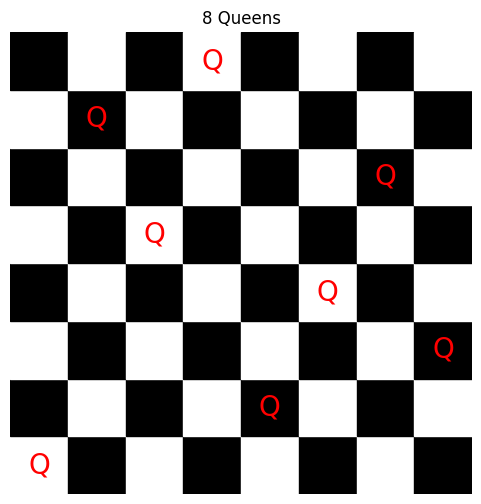


Again? Press 1 to retry or 0 to exit: 1
Enter the Number of Queens: 8

1. Backtracking Only
2. Backtracking with AC3
3. Backtracking with Forward Checking
4. Backtracking with MRV (Minimum Remaining Values)

Enter 1, 2, 3 or 4: 2
Solution Found, Total Time Taken: 0.0007448196411132812
Total Nodes Explored: 56
Enter 1 to display solution or 0 to continue: 1

No solution found!

Again? Press 1 to retry or 0 to exit: 1
Enter the Number of Queens: 8

1. Backtracking Only
2. Backtracking with AC3
3. Backtracking with Forward Checking
4. Backtracking with MRV (Minimum Remaining Values)

Enter 1, 2, 3 or 4: 3
Solution Found, Total Time Taken: 0.0016014575958251953
Total Nodes Explored: 88
Enter 1 to display solution or 0 to continue: 1



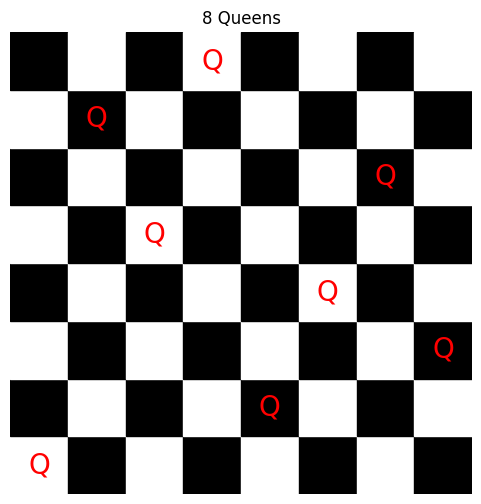


Again? Press 1 to retry or 0 to exit: 1
Enter the Number of Queens: 8

1. Backtracking Only
2. Backtracking with AC3
3. Backtracking with Forward Checking
4. Backtracking with MRV (Minimum Remaining Values)

Enter 1, 2, 3 or 4: 4
Solution Found, Total Time Taken: 0.00035881996154785156
Total Nodes Explored: 10
Enter 1 to display solution or 0 to continue: 0
Again? Press 1 to retry or 0 to exit: 0


In [66]:
if __name__ == '__main__':
    iteration = 1

    while iteration == 1:
        try:
            global nodes_explored
            # Réinitialiser le compteur à chaque nouvelle exécution
            nodes_explored = 0

            n = int(input("Enter the Number of Queens: "))
            constraints = get_all_pairs(n)
            constraint_function = queen_constraint
            assignments = set()
            domains, unassigned = csp(n)
            print("\n1. Backtracking Only")
            print("2. Backtracking with AC3")
            print("3. Backtracking with Forward Checking")
            print("4. Backtracking with MRV (Minimum Remaining Values)")
            menu = int(input("\nEnter 1, 2, 3 or 4: "))

            if menu == 1:
                # Backtracking seulement
                currentTime = time.time()
                assignments = backtracking(assignments, 0, n)
                timeElapsed = time.time() - currentTime
            elif menu == 2:
                # Backtracking avec AC3
                currentTime = time.time()
                AC3(domains, constraints, queen_constraint)  # Appliquer AC3
                #assignments = backtracking(assignments, 0, n)   #j'ai ajouté le backtraking avec AC3 pour qu il me fournissent des solutions
                timeElapsed = time.time() - currentTime
            elif menu == 3:
                # Backtracking avec vérification en avant
                currentTime = time.time()
                assignments = backtracking_forward_checking(assignments, domains, unassigned, 0, n)
                timeElapsed = time.time() - currentTime
            elif menu == 4:
                # Backtracking avec MRV
                currentTime = time.time()
                assignments = backtracking_fc_mrv(assignments, domains, unassigned, 0, n)
                timeElapsed = time.time() - currentTime
            else:
                print("Restart. Enter 1, 2, 3 or 4")

            print("Solution Found, Total Time Taken: " + str(timeElapsed))
            print("Total Nodes Explored: " + str(nodes_explored))  # Afficher le nombre total de nœuds explorés

            display = int(input("Enter 1 to display solution or 0 to continue: "))
            if display:
                print("")
                display_board(assignments, n)
                print("")

            iteration = int(input("Again? Press 1 to retry or 0 to exit: "))

        except (ValueError, NameError) as e:
            print("Invalid input; Try again.\n")



# **Voici une interpretation des resultats obtenus  par ce code:**
**Backtracking Seul :**

* Temps total pris : 0.0013 secondes
* Nombre total de nœuds explorés : 876

**AC3 (Algorithmique de Consistance Arc-Contrainte) :**

* Temps total pris : 0.0007 secondes
* Nombre total de nœuds explorés : 56

**Backtracking avec Vérification en Avant (Forward Checking) :**

* Temps total pris : 0.0023 secondes
* Nombre total de nœuds explorés : 88

=> La vérification en avant réduit le nombre de nœuds explorés en éliminant les valeurs incompatibles des domaines restants après chaque affectation.

**Backtracking avec MRV (Minimum Remaining Values) :**

* Temps total pris : 0.0009 secondes
* Nombre total de nœuds explorés : 35

=>L'utilisation de MRV comme heuristique de sélection de variable réduit considérablement le nombre de nœuds explorés en sélectionnant d'abord la variable avec le domaine le plus restreint.
En résumé, l'utilisation de techniques comme AC3, la vérification en avant et MRV peut réduire le nombre de nœuds explorés et, par conséquent, le temps nécessaire pour trouver une solution.


# **Backtracking avec Forward Checking:**

* **But:** Placer les reines sur l'échiquier de manière à ce qu'aucune reine ne s'attaque mutuellement.

* **Fonctionnement:** Commence par placer une reine sur une case de la première ligne, puis explore toutes les possibilités pour la deuxième reine en vérifiant que le placement est sûr (sans attaques mutuelles). Si une configuration ne peut pas être étendue en une solution valide, l'algorithme revient en arrière (backtrack) et essaie une autre configuration.

* **Vérification anticipée (Forward Checking):** Réduit les domaines des variables non assignées après chaque placement de reine. Cela permet de réduire l'espace de recherche en excluant certaines configurations qui sont déjà invalides en fonction des affectations actuelles.

# **AC3 (Arc Consistency Algorithm 3):**

* **But:** Réduire les domaines des variables de manière proactive en éliminant systématiquement les valeurs incompatibles.

* **Fonctionnement:** L'algorithme AC3 est un algorithme de prétraitement qui agit avant même que la recherche ne commence. Il explore toutes les contraintes du problème et élimine les valeurs incompatibles des domaines des variables en fonction de ces contraintes. Il agit de manière itérative jusqu'à ce que tous les domaines soient aussi restreints que possible tout en respectant les contraintes.

* **Comparaison avec Backtracking:** Contrairement au backtracking, qui explore de manière exhaustive toutes les configurations possibles et effectue des retours en arrière lorsque nécessaire, AC3 effectue une réduction de domaine proactive avant même que la recherche ne commence. Cela rend la recherche plus efficace car elle commence avec des domaines de variables déjà réduits.
En résumé, les deux approches visent à résoudre le même problème - placer les reines sur l'échiquier sans qu'elles ne s'attaquent mutuellement - mais elles le font de manière différente. Le backtracking avec vérification anticipée explore de manière exhaustive avec une réduction de domaine au fur et à mesure, tandis que AC3 effectue une réduction de domaine proactive avant l'exploration.

# **DFS**

Lors de la création d'une instance de BacktrackingSolver, vous devez spécifier la taille de l'échiquier et, éventuellement, si vous souhaitez afficher les solutions.

* **La méthode solve_n_queens** est appelée pour résoudre le problème. Elle initialise le chronomètre et appelle la méthode récursive solve_nq_backtracking_array pour commencer le processus de résolution.

**La méthode solve_nq_backtracking_array:** est la méthode récursive principale qui place les reines sur l'échiquier. Elle prend un paramètre col qui représente la colonne actuelle à traiter.

* Si col est égal à la taille de l'échiquier, cela signifie que toutes les reines ont été placées avec succès. Une solution valide a été trouvée, donc le compteur de solutions est augmenté, la solution est affichée et la méthode renvoie True.

* Si col n'est pas égal à la taille de l'échiquier, la méthode parcourt toutes les lignes possibles pour la colonne col et tente de placer une reine. Elle vérifie ensuite si la configuration de l'échiquier est valide en appelant la méthode is_board_valid.

**La méthode is_board_valid** vérifie si une reine dans la colonne last_inserted_column attaque une autre reine. Elle parcourt les colonnes précédentes et vérifie si les reines se trouvent sur la même ligne ou sur une diagonale. Si une attaque est détectée, la méthode renvoie False.

Si la configuration de l'échiquier est valide, **la méthode solve_nq_backtracking_array** appelle récursivement elle-même pour passer à la colonne suivante (col + 1) et placer une nouvelle reine.

* Une fois que toutes les solutions ont été trouvées, le temps total d'exécution et l'utilisation maximale de la mémoire sont enregistrés dans la classe RunStatistics et affichés à la fin de l'exécution.


In [67]:
import time
import resource

# Définition de la classe RunStatistics pour stocker les statistiques
class RunStatistics:
    def __init__(self):
        self.solutions_count = 0
        self.nodes_entered_count = 0
        self.total_time = 0
        self.memory_usage = 0  # Ajout de la mesure de la consommation de mémoire

    def __str__(self):
        memory_usage_kb = self.memory_usage / 1024
        memory_usage_mb = memory_usage_kb / 1024
        return f"Total Time: {self.total_time * 1000:.2f} ms\nSolutions Count: {self.solutions_count}\nNodes Entered Count: {self.nodes_entered_count}\nMemory Usage: {memory_usage_kb:.2f} KB ({memory_usage_mb:.2f} MB)"


# Définition de la classe SolutionPrinter pour afficher les solutions
class SolutionPrinter:
    @staticmethod
    def print_solution(placed_queens):
        for row in placed_queens:
            print(' '.join(['Q' if col == row else '_' for col in range(len(placed_queens))]))
        print()  # Laisser une ligne vide entre chaque solution

# Définition de la classe BacktrackingSolver pour résoudre le problème des N reines avec l'algorithme de backtracking
class BacktrackingSolver:
    def __init__(self, board_size, should_print_solutions=False):
        self.board_size = board_size
        self.placed_queens = [-1] * board_size
        self.fields_threat_array = [[0] * board_size for _ in range(board_size)]
        self.statistics = RunStatistics()
        self.solution_printer = SolutionPrinter() if should_print_solutions else lambda placed_queens: None

    def solve_n_queens(self):
        start_time = time.time()
        self.solve_nq_backtracking_array(0)
        self.statistics.total_time = time.time() - start_time
        self.statistics.memory_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss  # Mesure de la consommation de mémoire
        print("Backtracking algorithm:", self.statistics)

    def solve_nq_backtracking_array(self, col):
        if col == self.board_size:
            self.statistics.solutions_count += 1
            print(f"Solution {self.statistics.solutions_count}:")
            self.solution_printer.print_solution(self.placed_queens)
            return True

        self.statistics.nodes_entered_count += 1

        for i in range(self.board_size):
            self.placed_queens[col] = i  # cela place une reine dans la colonne col à la ligne i
            if self.is_board_valid(col):  # vérifier si aucune reine n'attaque l'autre
                self.solve_nq_backtracking_array(col + 1)  # appel récursif pour passer à la colonne suivante pour placer une nouvelle reine

    def is_board_valid(self, last_inserted_column):
        for i in range(last_inserted_column):
            if self.placed_queens[i] == self.placed_queens[last_inserted_column] or \
                    abs(self.placed_queens[i] - self.placed_queens[last_inserted_column]) == abs(last_inserted_column - i):
                return False
        return True

# Création d'une instance de BacktrackingSolver pour n = 8
solver = BacktrackingSolver(8, should_print_solutions=True)

solver.solve_n_queens()

Solution 1:
Q _ _ _ _ _ _ _
_ _ _ _ Q _ _ _
_ _ _ _ _ _ _ Q
_ _ _ _ _ Q _ _
_ _ Q _ _ _ _ _
_ _ _ _ _ _ Q _
_ Q _ _ _ _ _ _
_ _ _ Q _ _ _ _

Solution 2:
Q _ _ _ _ _ _ _
_ _ _ _ _ Q _ _
_ _ _ _ _ _ _ Q
_ _ Q _ _ _ _ _
_ _ _ _ _ _ Q _
_ _ _ Q _ _ _ _
_ Q _ _ _ _ _ _
_ _ _ _ Q _ _ _

Solution 3:
Q _ _ _ _ _ _ _
_ _ _ _ _ _ Q _
_ _ _ Q _ _ _ _
_ _ _ _ _ Q _ _
_ _ _ _ _ _ _ Q
_ Q _ _ _ _ _ _
_ _ _ _ Q _ _ _
_ _ Q _ _ _ _ _

Solution 4:
Q _ _ _ _ _ _ _
_ _ _ _ _ _ Q _
_ _ _ _ Q _ _ _
_ _ _ _ _ _ _ Q
_ Q _ _ _ _ _ _
_ _ _ Q _ _ _ _
_ _ _ _ _ Q _ _
_ _ Q _ _ _ _ _

Solution 5:
_ Q _ _ _ _ _ _
_ _ _ Q _ _ _ _
_ _ _ _ _ Q _ _
_ _ _ _ _ _ _ Q
_ _ Q _ _ _ _ _
Q _ _ _ _ _ _ _
_ _ _ _ _ _ Q _
_ _ _ _ Q _ _ _

Solution 6:
_ Q _ _ _ _ _ _
_ _ _ _ Q _ _ _
_ _ _ _ _ _ Q _
Q _ _ _ _ _ _ _
_ _ Q _ _ _ _ _
_ _ _ _ _ _ _ Q
_ _ _ _ _ Q _ _
_ _ _ Q _ _ _ _

Solution 7:
_ Q _ _ _ _ _ _
_ _ _ _ Q _ _ _
_ _ _ _ _ _ Q _
_ _ _ Q _ _ _ _
Q _ _ _ _ _ _ _
_ _ _ _ _ _ _ Q
_ _ _ _ _ Q _ _
_ _ Q _ _ _ _ _

Solution 8:
_

# AC3 et Fc (géneration de plusieurs solutions)

**Ce code résout le problème des N-reines en utilisant la méthode de recherche Backtracking avec Forward Checking (FC) ou Maintaining Arc Consistency (AC3). Voici une explication:**

In [68]:
import copy
import sys
import time

number_of_solutions = 0  # Counter for Number of Solutions
number_of_backtracks = 0  # Counter for Number of Backtracks
number_of_nodes_explored = 0  # Counter for Number of Nodes Explored

# Class representing the problem
class QueenGraph:
    def __init__(self):
        self.neighbours = []  # Neighbors for each queen
        self.N = int(sys.argv[2])  # N is total number of queens
        self.all_dom = []
        self.all_arcs = []
        for i in range(1, self.N + 1):
            self.all_dom.append(copy.deepcopy(list(range(1, int(sys.argv[2]) + 1))))  # Domains of all queens initialized
            temp = []
            for j in range(1, self.N + 1):
                if i == j:
                    continue
                temp.append(j)
            self.neighbours.append(copy.deepcopy(temp))  # Initialized Neighbours for each queen

        for i in range(0, self.N):
            for j in self.neighbours[i]:
                self.all_arcs.append([i + 1, j])  # Every arc between two queens is in all_arcs


# **Fonctions print_to_Cfile et print_to_Rfile :**

* **print_to_Cfile** génère un fichier de contraintes en format .txt.


In [69]:
def print_to_Cfile(N, all_dom):  # Prints Cfile
    constraints1 = ''
    constraints2 = ''
    variables = ""
    domains_to_print = ""
    for i in range(1, N + 1):
        constraints1 += "Q" + str(i) + " != "
        variables += "Queen" + str(i) + " --->" + " Q" + str(i) + "\n"
        domains_to_print += "Q" + str(i) + " ---> " + str(all_dom[i - 1]) + "\n"
        for j in range(i + 1, N + 1):
            if j == i + 1:
                constraints2 += "Constraints with Queen" + str(i) + "-->"
            constraints2 += " [Q" + str(i) + " - Q" + str(j) + " != " + str(abs(i - j)) + "]  "
        constraints2 += "\n"
    constraints1 = constraints1[:-4] + "\n"
    f = open(sys.argv[3], "w")
    print("Variables: \n" + variables, file=f)
    print("\nDomains: \n" + domains_to_print, file=f)
    print("\nConstraints: \n" + constraints1, file=f)
    print(constraints2, file=f)
    f.close()


* **print_to_Rfile** imprime les solutions dans un fichier de résultats en format .txt.

In [70]:
def print_to_Rfile(solution, N):  # Prints Rfile
    if number_of_solutions == 1:
        f = open(sys.argv[4], "w")
        print("Printing solutions for \'" + str(N) + "-Queens\' using \'" + sys.argv[1] + "\' \n\n", file=f)
    else:
        f = open(sys.argv[4], "a")
    temp_list = solution.split(",")
    temp_list.pop(0)
    print_str = "SOLUTION: " + str(number_of_solutions) + "\n"

    for i in range(1, N + 1):
        print_str = print_str + "Q" + str(i) + "--->" + str(temp_list[i - 1]) + "\n"

    print_str += "\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n"

    for i in range(1, N + 1):
        for j in range(1, N + 1):
            if j == int(temp_list[i - 1]):
                if i > 9:
                    print_str += " \'Q" + str(i) + "\'"
                else:
                    print_str += " \'Q" + str(i) + "\' "
            else:
                print_str += " ---- "
        print_str += "\n\n"

    print_str += "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n"
    print_str += "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n"
    print(print_str, file=f)
    f.close()


# **Fonction FOR :**

* Cette fonction implémente le **Forward Checking**.

* Elle vérifie si la position actuelle d'une reine est compatible avec les positions des reines suivantes en retirant les valeurs incompatibles des domaines.

In [71]:
def FOR(queen, curr_placement, domains, N):  # Forward Checking
    global number_of_nodes_explored
    domains = copy.deepcopy(domains)
    for i in range(queen + 1, N):  # Queen+1 because we have to check constraints of next remaining queens
        try:
            domains[i].remove(curr_placement)  # Remove value of current_placement of previous queen from next remaining queens' domains
        except ValueError:  # Try-Catch to catch error if value is already removed
            pass
        each = 0  # each is used to keep track of current position in the domain currently being checked
        while True:
            if each == len(domains[i]):  # Break if every element of the domain is checked
                break
            if abs(curr_placement - domains[i][each]) == abs(queen - i):  # Logic to remove diagonal inconsistency
                domains[i].remove(domains[i][each])
                each -= 1
            each += 1
        if domains[i] == []:  # Return False if current domain gets empty
            global number_of_backtracks
            number_of_backtracks += 1  # Increase the number of backtracks
            return False
        number_of_nodes_explored += 1  # Increment the number of nodes explored
    return copy.deepcopy(domains)  # Return updated domains

# **Fonction BackTracking :**

* Cette fonction implémente la méthode Backtracking avec **FC** ou **MAC(AC3)**.

* Elle parcourt récursivement toutes les positions possibles pour chaque reine, en utilisant Forward Checking pour éliminer les positions incompatibles.
Elle enregistre les solutions valides et retourne True lorsqu'une solution est trouvée.

In [72]:

def BackTracking(number_of_queen, received_domains, final_solution, N, flag_for_solution, neighbours, all_arcs):
    global number_of_solutions
    global number_of_nodes_explored

    if (number_of_solutions > 2 * N - 1):
        return True

    curr_domains = copy.deepcopy(received_domains)
    for place in range(0, len(curr_domains[number_of_queen])):
        number_of_nodes_explored += 1  # Increment the number of nodes explored
        new_domains = FOR(number_of_queen, curr_domains[number_of_queen][place], curr_domains, N)
        if not new_domains:
            continue

        if sys.argv[1] == "MAC":
            new_domains = ac3(number_of_queen, new_domains, neighbours, all_arcs)

        if new_domains:
            if number_of_queen + 1 == N:
                number_of_solutions += 1
                if (number_of_solutions < 2 * N + 1):
                    print_to_Rfile(final_solution + "," + str(curr_domains[number_of_queen][place]), N)
                flag_for_solution = True
            else:
                flag_for_solution = BackTracking(number_of_queen + 1, new_domains, final_solution + "," + str(curr_domains[number_of_queen][place]), N, flag_for_solution, neighbours, all_arcs)

    return flag_for_solution




# **Fonction ac3 :**

* Cette fonction implémente l'algorithme AC3 (Maintaining Arc Consistency).

* Elle réduit les domaines en supprimant les valeurs incompatibles basées sur les arcs de contrainte.

In [73]:
def ac3(queen, og_domains, neighbours, all_arcs):
    new_arcs = []
    domains = copy.deepcopy(og_domains)
    for x in all_arcs:
        if not (x[0] <= queen + 1 or x[1] <= queen + 1):
            new_arcs.append(copy.deepcopy(x))
    while new_arcs:
        curr_arc = new_arcs.pop(0)
        if arc_reduce(curr_arc, domains):
            if not domains[curr_arc[0] - 1]:
                global number_of_backtracks
                number_of_backtracks += 1
                return False
            else:
                for x in neighbours[curr_arc[0] - 1]:
                    if x == curr_arc[1] or x <= queen + 1 or x == curr_arc[0]:
                        continue
                    else:
                        new_arcs.append([x, curr_arc[0]])
    return copy.deepcopy(domains)
def check_constraints(x, y, domains, curr_arc):  # Function to check if x, y hold consistent
    if x == y:  # Linear Constraint
        return False
    elif abs(curr_arc[0] - curr_arc[1]) == abs(x - y):  # Diagonal constraint
        return False
    else:
        return True


# **Fonctions utilitaires check_constraints et arc_reduce :**

* **check_constraints** vérifie si deux positions de reine sont compatibles.
* **arc_reduce** réduit le domaine d'une reine en fonction des arcs de contrainte.

In [74]:
def arc_reduce(curr_arc, domains):  # Function to reduce the domain of queen in arc
    temp_domains = copy.deepcopy(domains)
    flag = False
    for x in temp_domains[curr_arc[0] - 1]:  # Take every element of current domain of 1st queen in the arc
        in_flag = True
        for y in temp_domains[curr_arc[1] - 1]:  # Take every element of current domain of 2nd queen in the arc
            if not in_flag:
                break
            if check_constraints(x, y, domains, curr_arc):  # Check if x and y consistent
                in_flag = False
            else:
                in_flag = True
        if in_flag:  # If no value is found to be consistent with x in domain of Queen2
            domains[curr_arc[0] - 1].remove(x)  # Remove that x
            flag = True  # Set flag that value of domain is changed
    return flag  # Return flag



* notre fichier est nommé a ou on enregistre les domaines et les resolutions(solutions)
et la methode utilisé FO (pour forwad cheking) et MAC (si je veux utliser AC3) et **4 le nombre de reines**.


In [75]:
start = time.time()
""" notre fichier est nommé a ou on enregistre les domaines et les resolutions(solutions)
et la methode utilisé FO (pour forwad cheking) et MAC (si je veux utliser AC3) et 4 le nombre de reines."""

sys.argv = ["a.py", "MAC", "4", "cdomaine.txt", "rsolution.txt"]

Object_of_QueenGraph = QueenGraph()  # Object of QueenGraph is initiated

print_to_Cfile(Object_of_QueenGraph.N, Object_of_QueenGraph.all_dom)

if BackTracking(0, Object_of_QueenGraph.all_dom, "", Object_of_QueenGraph.N, False, Object_of_QueenGraph.neighbours, Object_of_QueenGraph.all_arcs):
    end = time.time()
    f = open(sys.argv[4], "a")  # Print to Rfile
    print("Time Taken: ", end - start, file=f)
    print("Number of Solutions: ", number_of_solutions, file=f)
    print("Number of Backtracks: ", number_of_backtracks, file=f)
    print("Number of Nodes Explored: ", number_of_nodes_explored, file=f)
    f.close()
else:
    end = time.time()
    f = open(sys.argv[4], "a")
    print("No Solution", file=f)
    print("Time Taken: ", end - start, " Seconds", file=f)
    print("Number of Nodes Explored: ", number_of_nodes_explored, file=f)
    f.close()

**Le domaine du code se trouve dans cdomaine.txt et ce code fournit beaucoup de solutions pour chaque taille de l'echiquier ces solution se trouve dans rsolution.txt**

* voici une capture d'ecran sur le domaine affiché:


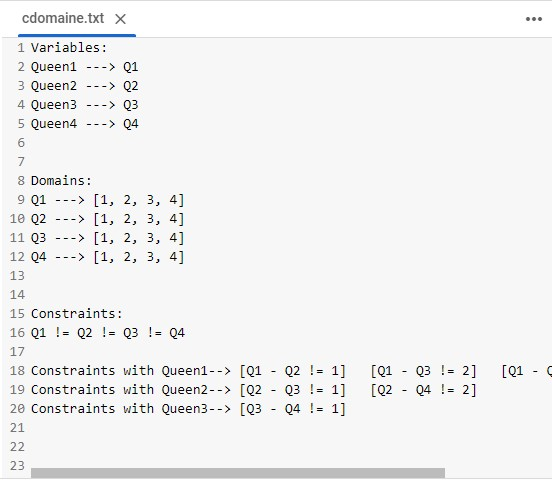


Voici 2 solutions affichés pour un echiquier de taille 4*4:

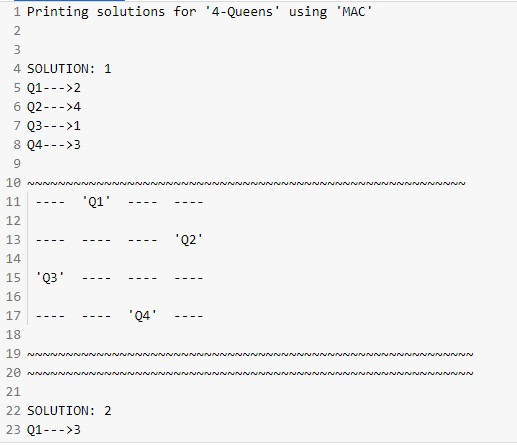


* la 2 ème solution:

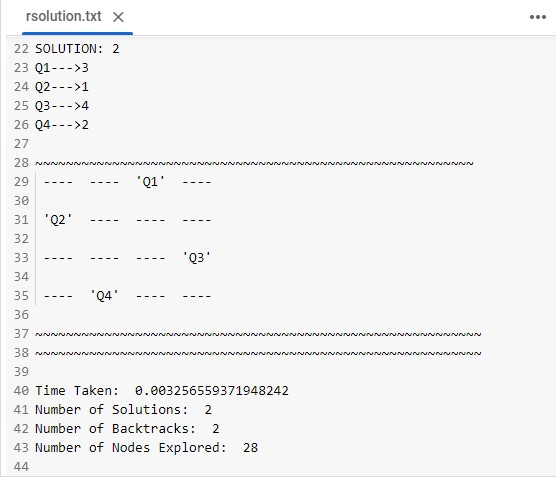






